# Import and misc

In [2]:
!pip install torchaudio==0.9.1

     |████████████████████████████████| 1.9 MB 5.4 MB/s 
     |████████████████████████████████| 831.4 MB 6.8 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.9.0+cu111
    Uninstalling torch-1.9.0+cu111:
      Successfully uninstalled torch-1.9.0+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.10.0+cu111 requires torch==1.9.0, but you have torch 1.9.1 which is incompatible.
torchtext 0.10.0 requires torch==1.9.0, but you have torch 1.9.1 which is incompatible.


In [3]:
from typing import Tuple
from tqdm import tqdm
from itertools import islice
import dataclasses

import numpy as np

import torch
import torch.nn.functional as F
from torch import nn
from torch import distributions
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torch.nn.utils.rnn import pad_sequence

import torchaudio
from IPython import display as display_

In [4]:
def count_parameters(model):
    return sum([p.numel() for p in model.parameters() if p.requires_grad])

# Task

In this notebook we will implement a model for finding a keyword in a stream.

We will implement the version with CRNN because it is easy and improves the model. 
(from https://www.dropbox.com/s/22ah2ba7dug6pzw/KWS_Attention.pdf)

In [5]:
@dataclasses.dataclass
class TaskConfig:
    keyword: str = 'sheila'  # We will use 1 key word -- 'sheila'
    batch_size: int = 256
    learning_rate: float = 3e-4
    weight_decay: float = 1e-5
    num_epochs: int = 35
    n_mels: int = 40
    kernel_size: Tuple[int, int] = (20, 5)
    stride: Tuple[int, int] = (8, 2)
    hidden_size: int = 128
    gru_num_layers: int = 2
    bidirectional: bool = True
    num_classes: int = 2
    sample_rate: int = 16000
    device: torch.device = torch.device(
        'cuda:0' if torch.cuda.is_available() else 'cpu')

# Data

In [6]:
!wget https://gist.githubusercontent.com/Kirili4ik/6ac5c745ff8dad094e9c464c08f66f3e/raw/63daacc17f52a7d90f7f4166a3f5deef62b165db/dataset_utils.py

--2021-11-07 15:06:42--  https://gist.githubusercontent.com/Kirili4ik/6ac5c745ff8dad094e9c464c08f66f3e/raw/63daacc17f52a7d90f7f4166a3f5deef62b165db/dataset_utils.py
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3475 (3.4K) [text/plain]
Saving to: ‘dataset_utils.py’

dataset_utils.py    100%[===================>]   3.39K  --.-KB/s    in 0s      

2021-11-07 15:06:42 (34.2 MB/s) - ‘dataset_utils.py’ saved [3475/3475]



In [7]:
from dataset_utils import DatasetDownloader, TrainDataset

dataset_downloader = DatasetDownloader(TaskConfig.keyword)
labeled_data, _ = dataset_downloader.generate_labeled_data()

labeled_data.sample(3)

Ready!
Classes: bed, bird, cat, dog, down, eight, five, four, go, happy, house, left, marvin, nine, no, off, on, one, right, seven, sheila, six, stop, three, tree, two, up, wow, yes, zero
Creating labeled dataframe:


100%|██████████| 31/31 [06:25<00:00, 12.44s/it]


,name,word,label
46789,speech_commands/house/257e17e0_nohash_0.wav,house,0
24551,speech_commands/right/26b28ea7_nohash_0.wav,right,0
29539,speech_commands/go/bfb10243_nohash_0.wav,go,0


### Augmentations

In [8]:
class AugsCreation:

    def __init__(self):
        self.background_noises = [
            'speech_commands/_background_noise_/white_noise.wav',
            'speech_commands/_background_noise_/dude_miaowing.wav',
            'speech_commands/_background_noise_/doing_the_dishes.wav',
            'speech_commands/_background_noise_/exercise_bike.wav',
            'speech_commands/_background_noise_/pink_noise.wav',
            'speech_commands/_background_noise_/running_tap.wav'
        ]

    def add_rand_noise(self, audio):

        # randomly choose noise
        noise_num = torch.randint(low=0, high=len(
            self.background_noises), size=(1,)).item()
        noise = torchaudio.load(self.background_noises[noise_num])[0].squeeze()

        noise_level = torch.Tensor([1])  # [0, 40]

        noise_energy = torch.norm(noise)
        audio_energy = torch.norm(audio)
        alpha = (audio_energy / noise_energy) * \
            torch.pow(10, -noise_level / 20)

        start = torch.randint(low=0, high=int(
            noise.size(0) - audio.size(0) - 1), size=(1,)).item()
        noise_sample = noise[start: start + audio.size(0)]

        audio_new = audio + alpha * noise_sample
        audio_new.clamp_(-1, 1)
        return audio_new

    def __call__(self, wav):
        aug_num = torch.randint(low=0, high=4, size=(1,)).item()   # choose 1 random aug from augs
        augs = [
            lambda x: x,
            lambda x: (x + distributions.Normal(0, 0.01).sample(x.size())).clamp_(-1, 1),
            lambda x: torchaudio.transforms.Vol(.25)(x),
            lambda x: self.add_rand_noise(x)
        ]

        return augs[aug_num](wav)

In [9]:
indexes = torch.randperm(len(labeled_data))
train_indexes = indexes[:int(len(labeled_data) * 0.8)]
val_indexes = indexes[int(len(labeled_data) * 0.8):]

train_df = labeled_data.iloc[train_indexes].reset_index(drop=True)
val_df = labeled_data.iloc[val_indexes].reset_index(drop=True)

In [10]:
# Sample is a dict of utt, word and label
transform_tr = AugsCreation()
train_set = TrainDataset(df=train_df, kw=TaskConfig.keyword, transform=transform_tr)
val_set = TrainDataset(df=val_df, kw=TaskConfig.keyword)

### Sampler for oversampling:

In [11]:
# We should provide to WeightedRandomSampler _weight for every sample_; by default it is 1/len(target)

def get_sampler(target):
    class_sample_count = np.array(
        [len(np.where(target == t)[0]) for t in np.unique(target)])   # for every class count it's number of occ.
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[t] for t in target])
    samples_weight = torch.from_numpy(samples_weight)
    samples_weigth = samples_weight.double()
    sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
    return sampler

In [12]:
train_sampler = get_sampler(train_set.df['label'].values)
val_sampler = get_sampler(val_set.df['label'].values)

In [13]:
class Collator:
    
    def __call__(self, data):
        wavs = []
        labels = []    

        for el in data:
            wavs.append(el['utt'])
            labels.append(el['label'])

        # torch.nn.utils.rnn.pad_sequence takes list(Tensors) and returns padded (with 0.0) Tensor
        wavs = pad_sequence(wavs, batch_first=True)    
        labels = torch.Tensor(labels).long()
        return wavs, labels

###  Dataloaders

In [14]:
# Here we are obliged to use shuffle=False because of our sampler with randomness inside.

train_loader = DataLoader(train_set, batch_size=TaskConfig.batch_size,
                          shuffle=False, collate_fn=Collator(),
                          sampler=train_sampler)
#                           num_workers=2, pin_memory=True)

val_loader = DataLoader(val_set, batch_size=TaskConfig.batch_size,
                        shuffle=False, collate_fn=Collator(),
                        sampler=val_sampler,
                        num_workers=2, pin_memory=True)

### Creating MelSpecs on GPU for speeeed: 

In [15]:
class LogMelspec():

    def __init__(self, is_train, config):
        # with augmentations
        if is_train:
            self.melspec = nn.Sequential(
                torchaudio.transforms.MelSpectrogram(
                    sample_rate=config.sample_rate,  n_mels=config.n_mels),
                torchaudio.transforms.FrequencyMasking(freq_mask_param=15),
                torchaudio.transforms.TimeMasking(time_mask_param=35),
            ).to(config.device)

        # no augmentations
        else:
            self.melspec = torchaudio.transforms.MelSpectrogram(
                sample_rate=config.sample_rate,
                n_mels=config.n_mels
            ).to(config.device)

    def __call__(self, batch):
        # already on device
        return torch.log(self.melspec(batch).clamp_(min=1e-9, max=1e9))

In [16]:
melspec_train = LogMelspec(is_train=True, config=TaskConfig)
melspec_val = LogMelspec(is_train=False, config=TaskConfig)

### Quality measurment functions:

In [17]:
# FA - true: 0, model: 1
# FR - true: 1, model: 0

def count_FA_FR(preds, labels):
    FA = torch.sum(preds[labels == 0])
    FR = torch.sum(labels[preds == 0])
    
    # torch.numel - returns total number of elements in tensor
    return FA.item() / torch.numel(preds), FR.item() / torch.numel(preds)

In [18]:
def get_au_fa_fr(probs, labels):
    sorted_probs, _ = torch.sort(probs)
    sorted_probs = torch.cat((torch.Tensor([0]), sorted_probs, torch.Tensor([1])))
    labels = torch.cat(labels, dim=0)
        
    FAs, FRs = [], []
    for prob in sorted_probs:
        preds = (probs >= prob) * 1
        FA, FR = count_FA_FR(preds, labels)        
        FAs.append(FA)
        FRs.append(FR)
    # plt.plot(FAs, FRs)
    # plt.show()

    # ~ area under curve using trapezoidal rule
    return -np.trapz(FRs, x=FAs)

### Model

In [19]:
# Pay attention to _groups_ param

def SepConv(in_size, out_size, kernel_size, stride, padding=0):
    return nn.Sequential(
        torch.nn.Conv1d(in_size, in_size, kernel_size[1],
                        stride=stride[1], groups=in_size,
                        padding=padding),

        torch.nn.Conv1d(in_size, out_size, kernel_size=1,
                        stride=stride[0], groups=int(in_size / kernel_size[0]))
    )

In [20]:
class CRNN(nn.Module):
    
    def __init__(self, config):
        super(CRNN, self).__init__()

        self.sepconv = SepConv(in_size=config.n_mels, out_size=config.hidden_size,
                               kernel_size=config.kernel_size, stride=config.stride)

        self.gru = nn.GRU(input_size=config.hidden_size, hidden_size=config.hidden_size,
                          num_layers=config.gru_num_layers,
                          dropout=0.1,
                          bidirectional=config.bidirectional)

    def forward(self, x, hidden):
        x = self.sepconv(x)

        # (BS, hidden, seq_len) ->(seq_len, BS, hidden)
        x = x.permute(2, 0, 1)
        x, hidden = self.gru(x, hidden)
        # x : (seq_len, BS, hidden * num_dirs)
        # hidden : (num_layers * num_dirs, BS, hidden)

        return x, hidden

In [21]:
class AttnMech(nn.Module):

    def __init__(self, config):
        super(AttnMech, self).__init__()

        ratio = 2 if config.bidirectional else 1
        lin_size = config.hidden_size * ratio

        self.Wx_b = nn.Linear(lin_size, lin_size)
        self.Vt = nn.Linear(lin_size, 1, bias=False)

    def forward(self, inputs, data=None):

        # count only 1 e_t
        if data is None:
            x = inputs
            x = torch.tanh(self.Wx_b(x))
            e = self.Vt(x)
            return e

        # recount attention for full vector e
        e = inputs
        # (BS, seq_len, hid_size*num_dirs)
        data = data.transpose(0, 1)
        alphas = F.softmax(e, dim=-1).unsqueeze(1)
        c = torch.matmul(alphas, data).squeeze()   # attetntion_vector
        return c

In [22]:
class FullModel(nn.Module):

    def __init__(self, config, CRNN_model, attn_layer):
        super(FullModel, self).__init__()

        self.CRNN_model = CRNN_model
        self.attn_layer = attn_layer

        # ll_in_size, ll_out_size = HIDDEN_SIZE * GRU_NUM_DIRS, NUM_CLASSES
        # last layer
        ratio = 2 if config.bidirectional else 1
        self.U = nn.Linear(config.hidden_size * ratio,
                           config.num_classes, bias=False)

    def forward(self, batch, hidden=None):
        output, hidden = self.CRNN_model(batch, hidden)
        # output : (seq_len, BS, hidden * num_dirs)
        # hidden : (num_layers * num_dirs, BS, hidden)

        e = []
        for seq_el in output:
            e_t = self.attn_layer(seq_el)  # (BS, 1)
            e.append(e_t)
        e = torch.cat(e, dim=1)           # (BS, seq_len)

        c = self.attn_layer(e, output)    # attention_vector
        Uc = self.U(c)
        return Uc               # we will need to get probs, so we use return logits

In [23]:
def train_epoch(model, opt, loader, log_melspec, device):
    model.train()
    for i, (batch, labels) in tqdm(enumerate(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        opt.zero_grad()

        # run model # with autocast():
        logits = model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(logits, dim=-1)
        loss = F.cross_entropy(logits, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)

        opt.step()

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        FA, FR = count_FA_FR(argmax_probs, labels)
        acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)

    return acc

In [24]:
@torch.no_grad()
def validation(model, loader, log_melspec, device):
    model.eval()

    val_losses, accs, FAs, FRs = [], [], [], []
    all_probs, all_labels = [], []
    for i, (batch, labels) in tqdm(enumerate(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        output = model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(output, dim=-1)
        loss = F.cross_entropy(output, labels)

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        all_probs.append(probs[:, 1].cpu())
        all_labels.append(labels.cpu())
        val_losses.append(loss.item())
        accs.append(
            torch.sum(argmax_probs == labels).item() /  # ???
            torch.numel(argmax_probs)
        )
        FA, FR = count_FA_FR(argmax_probs, labels)
        FAs.append(FA)
        FRs.append(FR)

    # area under FA/FR curve for whole loader
    au_fa_fr = get_au_fa_fr(torch.cat(all_probs, dim=0).cpu(), all_labels)
    return au_fa_fr

In [25]:
from collections import defaultdict
from IPython.display import clear_output
from matplotlib import pyplot as plt

history = defaultdict(list)

In [26]:
CRNN_model = CRNN(TaskConfig)
attn_layer = AttnMech(TaskConfig)
full_model = FullModel(TaskConfig, CRNN_model, attn_layer)
full_model = full_model.to(TaskConfig.device)

print(full_model)

opt = torch.optim.Adam(full_model.parameters(),
                       lr=TaskConfig.learning_rate, weight_decay=TaskConfig.weight_decay)

FullModel(
  (CRNN_model): CRNN(
    (sepconv): Sequential(
      (0): Conv1d(40, 40, kernel_size=(5,), stride=(2,), groups=40)
      (1): Conv1d(40, 128, kernel_size=(1,), stride=(8,), groups=2)
    )
    (gru): GRU(128, 128, num_layers=2, dropout=0.1, bidirectional=True)
  )
  (attn_layer): AttnMech(
    (Wx_b): Linear(in_features=256, out_features=256, bias=True)
    (Vt): Linear(in_features=256, out_features=1, bias=False)
  )
  (U): Linear(in_features=256, out_features=2, bias=False)
)


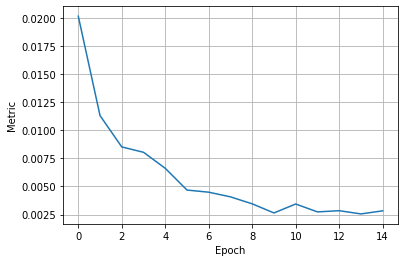

END OF EPOCH 14


In [27]:
# TRAIN

for n in range(15):

    train_epoch(full_model, opt, train_loader,
                melspec_train, TaskConfig.device)

    au_fa_fr = validation(full_model, val_loader,
                          melspec_val, TaskConfig.device)
    history['val_metric'].append(au_fa_fr)

    clear_output()
    plt.plot(history['val_metric'])
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()

    print('END OF EPOCH', n)